<a href="https://colab.research.google.com/github/miguelamda/DL/blob/master/5.%20Redes%20Convolucionales/Practica5.3.%20CNN%20Preentrenadas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PRÁCTICA 5.3. REDES CONVOLUCIONALES PRE-ENTRENADAS

Una aproximación muy común y efectiva cuando se trabaja con Deep Learning sobre datasets pequeños es reutilizar redes preentrenadas. Una red preentrenada es simplemente una red grabada que ha sido entrenada sobre un dataset grande, algo muy común cuando se trabaja con problemas de clasificación de imágenes. 

Si este dataset original es suficientemente grande y suficientemente general, entonces la jerarquía de características espaciales que ha aprendido la red preentrenada puede servir como modelo genérico de nuestro mundo visual y, por tanto, sus características pueden ser útiles para muchos problemas de visión diferentes, incluso aunque estos nuevos problemas involucren clases completamente distintas a las de la tarea original. 

Por ejemplo, uno puede entrenar una red sobre [ImageNet](http://www.image-net.org) (donde las clases son principalmente de animales y objetos de uso diario) y reutilizarlo para algo tan distinto como identificar muebles. Esta portabilidad de características aprendidas entre diferentes problemas (que se suele denominar **Transfer Learning**, o **Transferencia de Aprendizaje**) es una ventaja clave de Deep Learning en comparación con muchas otras aproximaciones clásicas de ML, y hace que DL pueda ser apropiado para atacar problemas con datasets pequeños (en contra de lo que se cree generalmente).

En el ejemplo que vamos a ver a continuación consideraremos una CNN entrenada sobre el dataset ImageNet (usando 1,4 millones de imágenes etiquetadas en 1.000 clases diferentes), que contiene clases de muchos animales, en particular diferentes razas de gatos y perros, así que podemos esperar que funcione bien sobre el problema de clasificación que vimos en el ejemplo anterior (Cats and Dogs).

Vamos a usar la arquitectura [VGG16](http://www.robots.ox.ac.uk/~vgg/research/very_deep/), desarrollada por Karen Simonyan y Andrew Zisserman en 2014, y que ha sido muy usada desde entonces para este tipo de problemas. Aunque es un modelo un poco viejo, y ya ha sido superado por muchos otros modelos similares, lo usaremos porque hace uso de arquitecturas parecidas a las de ejemplos anteriores, permitiéndonos concentrarnos en las novedades que introduciremos.

![](https://github.com/miguelamda/DL/blob/master/5.%20Redes%20Convolucionales/imgs/vgg16.png?raw=1)

En lo que sigue, vamos a hacer dos aproximaciones para reutilizar modelos pre-entrenados: **Extracción de Características** y **Ajuste Fino**.

Por último, para poder probar los modelos con varias imágenes, primero debes tener la carpeta imgs adjuntada en el repositorio del curso.

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import datasets, transforms, models
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import PIL

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


## 1. Inferencia con modelos

Para utilizar un modelo entrenado en PyTorch para hacer **inferencia** (predicción), es fundamental seguir una serie de pasos para garantizar que el modelo reciba los datos en el formato que éste espera. El proceso de inferencia se centra en replicar las condiciones del entrenamiento, pero optimizado para velocidad y estabilidad:

1.  Asegurar el **Modo Evaluación** y **Desactivar Gradientes**, mediante `.eval()` y `torch.no_grad()`. Con `model.eval()` desactivamos las capas con comportamiento estocástico como `nn.Dropout` y asegura que `nn.BatchNorm` deje de usar las estadísticas del lote actual y utilice las *estadísticas acumuladas* durante el entrenamiento. Además, debes envolver el pase hacia adelante con `with torch.no_grad():`, ya que esto desactiva el cálculo de gradientes, acelerando la inferencia y reduciendo drásticamente el uso de memoria.

2.  **Preprocesamiento** y Formato del Tensor: La imagen de entrada debe ser preprocesada exactamente de la misma manera que las imágenes de entrenamiento (esto es algo ya que discutimos en el módulo 3). Esto incluye:
    * *Transformaciones:* Redimensionar (`transforms.Resize`), recortar (`transforms.CenterCrop`) y aplicar la normalización (`transforms.Normalize`) con la media y desviación estándar utilizadas durante el entrenamiento (p.ej. las de ImageNet).
    * *Formato de Tensor:* La imagen debe convertirse a un tensor de PyTorch con la forma canónica `(Canal, Alto, Ancho)`.

3.  Dimensiones del **Batch** y **Dispositivo**: Aunque solo tengas una imagen, PyTorch (y la mayoría de los *frameworks* de *deep learning*) esperan las entradas en **lotes (batches)**. Por lo tanto, debes añadir una dimensión al inicio del tensor, transformando la forma a `(1, C, H, W)`** usando `.unsqueeze(0)`. Finalmente, el tensor de entrada debe estar en el mismo dispositivo que el modelo (GPU o CPU) usando `.to(device)`. 

Por ejemplo, podemos cargar el modelo que entrenamos en la práctica anterior de la siguiente forma:


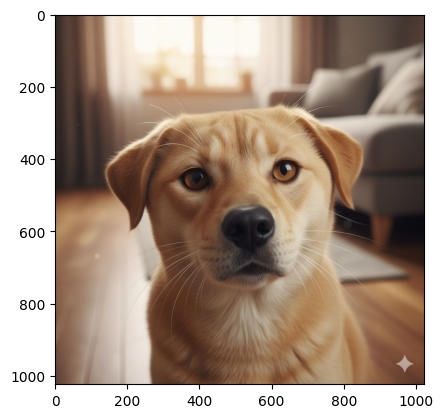

Es un perro con certeza de un  0.9622200131416321


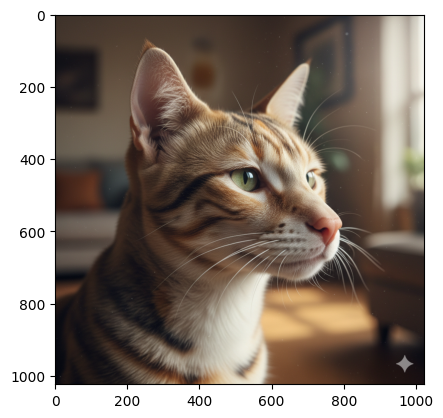

Es un perro con certeza de un  0.0016527717234566808


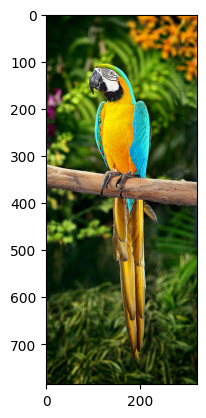

Es un perro con certeza de un  0.9999946355819702


In [2]:
# Cargamos la definición de bloque convolucional de la práctica anterior
from bloques import BloqueConvolucional  

# Cargamos el modelo en la GPU
model = torch.load('cats_and_dogs_DADB.pth', map_location=device)
#print(model)

def inferencia(image_path):
    img = PIL.Image.open(image_path)
    plt.imshow(img)  
    plt.show()  

    # Preprocesamos la imagen tal y como hicimos con el dataset cats vs dogs
    # Recuerda: normalizábamos a rango [0,1] y reajustamos el tamaño a 150x150
    trans = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor()
    ])
    input_image = trans(img)

    # Introducimos la imagen en un batch y lo enviamos a la GPU
    input_batch = input_image.unsqueeze(0).to(device)

    # Hacemos inferencia, ¿qué cree el modelo que es?
    model.eval()
    with torch.no_grad():
        pred = model(input_batch)
    # Imprimimos la inferencia del modelo
    print("Es un perro con certeza de un ", F.sigmoid(pred).item())

# Leemos una imagen de prueba
inferencia('./imgs/Gemini_dogcat.png')
inferencia('./imgs/Gemini_catdog.png')
inferencia('./imgs/parrot.jpg')

# Eliminamos el modelo, ya que no nos hará falta
del(model)

## 2. Clasificación de imágenes con VGG16

Antes de continuar, vamos a analizar qué tal se comporta la red VGG16, pre-entrenada sobre el dataset [ImageNet](http://www.image-net.org/). Primero tendremos que obtener dicho modelo, lo cual es sencillo con PyTorch. A continuación nos descargaremos el modelo VGG16 ya disponible en Torchvision.

In [3]:
modeloVGG16 = models.vgg16(pretrained=True)

/usr/local/lib64/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib64/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Vamos a definir una serie de funciones auxiliares que nos ayudarán en la tarea de clasificar imágenes. Por un lado, necesitamos una función que preprocese las imágenes previo a pasarlas por la red. Y es que las redes pre-entrenadas tienen en común que han estandarlizado las imágenes con la media y desviación de todo el dataset Imagenet. Por otro lado, necesitamos decodificar las clases. Ahora tenemos 1000 clases, es imposible recordarlas todas, por lo que usar tan solo el índice de la clase no es suficiente, necesitamos los nombres de las etiquetas. Por último, haremos una función que: muestre la imagen, la clasifica usando el modelo cargado, e imprime las puntuaciones (scores) de clasificación. 

La siguiente función hace el preprocesamiento que se hace a todas las imágenes antes de introducirlas en un modelo pre-entrenado de Torchvision.

In [4]:
# La rutina estándar para cualquier modelo preentrenado de torchvision
def preprocess_image(image):
    transform = transforms.Compose([            
        transforms.Resize(256),                    
        transforms.CenterCrop(224),                
        transforms.ToTensor(),                     
        transforms.Normalize(                      
        mean=[0.485, 0.456, 0.406],     # media de ImageNet           
        std=[0.229, 0.224, 0.225]       # desviación de ImageNet
        )])

    return transform(image)


El modelo nos dará la probabilidad de que una imagen pertenezca a cada clase. Sin embargo, si la clase con el mayor valor de probabilidad es la clase número 674, qué significa? Qué clase es la 674? Por suerte hay un diccionario que nos dice para ImageNet, qué significa cada clase. A continuación descargamos y procesamos dicho fichero, y definimos una función que toma los k valores más altos y los decodifica.

In [33]:
import urllib.request
import json
import torch.nn.functional as F

IMAGENET_CLASSES_URL = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
FILE_NAME = "imagenet_classes.json"

def download_and_load_imagenet_classes(url, filename):
    # Descargamos el fichero
    urllib.request.urlretrieve(url, filename)
    
    # Cargar el archivo JSON
    with open(filename, 'r') as f:        
        data = json.load(f)
        
    class_map = {int(k): v[1] for k, v in data.items()}
    
    return class_map

imagenet_map = download_and_load_imagenet_classes(IMAGENET_CLASSES_URL, FILE_NAME)

def decode_topk_predictions(output_tensor, class_map, k=5):    
    
    # 1. Aplicamos Softmax a los logits generados por el modelo
    # ¡Softmax trabaja con batches! Por eso usamos unsqueeze
    probabilities = F.softmax(output_tensor, dim=1) 
    
    # 2. Top-K (encuentra los K mejores)
    topk_prob, top_class_indices = torch.topk(probabilities, k=k, dim=1)
    
    # 3. Decodificación de los ejemplos en el batch
    for j in range(topk_prob.size(0)):
        print("\n--- Top ",k," Predicciones Imagen ",j," ---")
        for i in range(topk_prob[j].size(0)):
            # Obtiene el índice y el nombre de la clase
            score = topk_prob[j][i].item()
            class_index = top_class_indices[j][i].item()
            
            # Aquí asumimos que class_map devuelve el nombre legible
            name = class_map.get(class_index)
            
            # Imprime la predicción formateada
            print("{0:>6.2%} : {1}".format(score, name))
    return topk_prob, top_class_indices

Finalmente, esta función funciona de forma parecida a `infiere` que hemos hecho antes, pero trabaja con VGG16 y con clases de ImageNet.

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL

def predict(model,image_path):
    # Carga y redimensiona la imagen usando PIL.
    img = PIL.Image.open(image_path)
    
    # Redimensionamos a tamaño de ImageNet para visualizar cómo
    # queda la imagen
    img_resized = img.resize((224,224), PIL.Image.LANCZOS)

    # Dibuja la imagen.
    plt.imshow(img_resized)
    plt.axis(False)
    plt.show()

    # Convierte la imagen PIL a un numpy-array con la forma (shape) apropiada.
    img_array = preprocess_image(img)

    # Añade una dimensión de batch: (C, H, W) -> (1, C, H, W)
    input_batch = img_array.unsqueeze(0)

    # --- INFERENCIA ---
    # Coloca el modelo en modo evaluación (desactiva Dropout y BatchNorm)
    model.eval() 
    
    # Usa el modelo VGG16 para hacer la predicción.
    # Esto devuelve un array con 1000 números, correspondientes a
    # las clases del dataset ImageNet.
    with torch.no_grad():
        # Mueve la entrada a la GPU si está disponible
        if torch.cuda.is_available():
            input_batch = input_batch.to('cuda')
            model = model.to('cuda')
            
        # Pasa hacia adelante (forward pass)
        output_batch = model(input_batch) 
    
    # Pasa las salidas de vuelta a la CPU si estaban en GPU
    output_batch = output_batch.cpu()

    # Decodifica la salida del modelo VGG16.
    decode_topk_predictions(output_batch,imagenet_map)

Usemos el modelo VGG16 en la foto del loro que debería ser clasificado como guacamayo (macaw, una especie de loro).

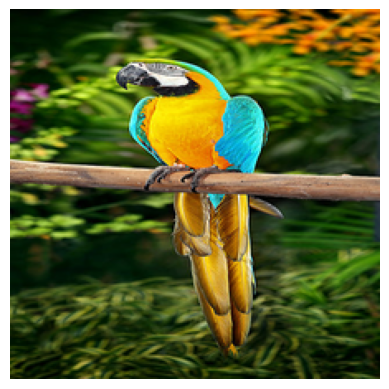


--- Top  5  Predicciones Imagen  0  ---
99.73% : macaw
 0.24% : toucan
 0.03% : bee_eater
 0.00% : hornbill
 0.00% : lorikeet


In [35]:
predict(model=modeloVGG16,image_path='imgs/parrot.jpg')

El modelo VGG16 funciona con imágenes de entrada de 224 x 224 píxeles de tamaño. La imagen de arriba de un loro tiene en realidad 320 píxeles de ancho y 785 píxeles de alto, por lo que es redimensionada automáticamente para el modelo VGG16. Podemos ver que ha sido apretado para que sea cuadrado, y la resolución se ha reducido para que la imagen sea más pixelada y granulada.

En este caso, el modelo VGG16 acierta clasificando la imagen como un guacamayo con un 99,7%, y un tucán con un solo 0,24%.

### Imagen Recortada, arriba

Esta imagen del loro se ha recortado manualmente a una dimensión cercana a 224 x 224 píxeles y luego se ha introducido en el modelo. Ahora sí, VGG16 está seguro (puntuación de alrededor del 79%) de que muestra un loro (guacamayo).

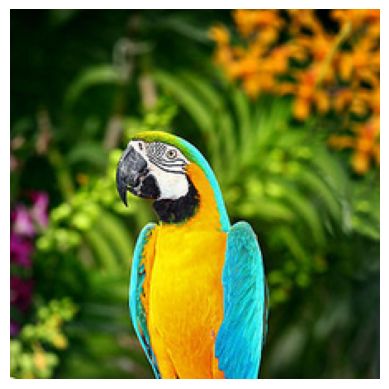


--- Top  5  Predicciones Imagen  0  ---
99.99% : macaw
 0.00% : peacock
 0.00% : hornbill
 0.00% : lorikeet
 0.00% : toucan


In [37]:
predict(model=modeloVGG16,image_path='imgs/parrot_cropped1.jpg')

### Imagen Recortada, en el centro

Esto es otro recorte de la imagen del loro, esta vez mostrando su cuerpo sin cabeza ni cola. El modelo VGG16 tiene un poco menos de confianza (puntuación de alrededor del 98%) de que muestra un loro guacamayo. El modelo debe haber aprendido a detectarlo por la cabeza, no por su su cuerpo.

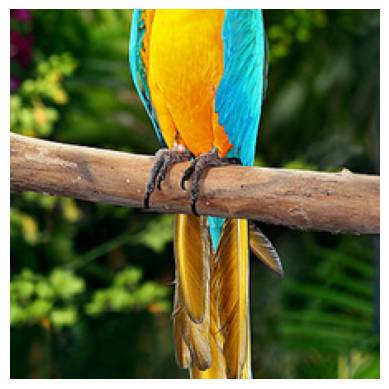


--- Top  5  Predicciones Imagen  0  ---
98.25% : macaw
 1.72% : toucan
 0.01% : hornbill
 0.01% : bee_eater
 0.00% : lorikeet


In [38]:
predict(model=modeloVGG16,image_path='imgs/parrot_cropped2.jpg')

### Imagen Recortada, abajo

Esta imagen ha sido recortada por lo que sólo muestra la cola del loro. Ahora el modelo VGG16 está confundido, piensa que podría tratarse de una mantis con un 25%, y un macaw con solo un 8%, también podría mostrar un merópido con un 17% y un jacamar con un 8%, que son otras aves exóticas. 

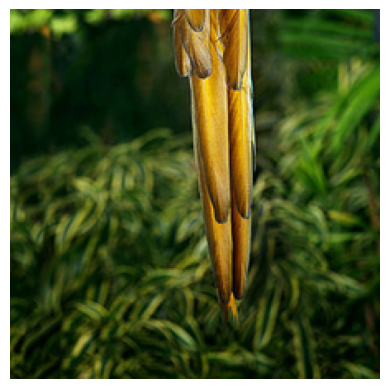


--- Top  5  Predicciones Imagen  0  ---
25.65% : mantis
17.02% : bee_eater
 8.77% : jacamar
 8.40% : macaw
 8.10% : hornbill


In [39]:
predict(model=modeloVGG16,image_path='imgs/parrot_cropped3.jpg')

### Imagen Rellenada

La mejor manera de introducir imágenes es rellenar la imagen para que sea cuadrada (en blanco a los lados) y luego redimensionarla a 240 x 240 píxeles. Sin embargo, este ejemplo del guacamayo baja a un 97%. 

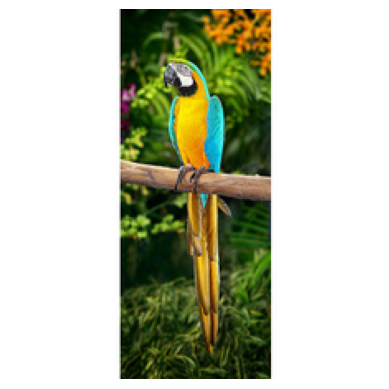


--- Top  5  Predicciones Imagen  0  ---
97.38% : macaw
 1.01% : lorikeet
 0.79% : bee_eater
 0.64% : toucan
 0.14% : jacamar


In [40]:
predict(model=modeloVGG16,image_path='imgs/parrot_padded.jpg')

### Elon Musk

#### 299 x 299 píxeles

Esta imagen muestra al empresario, fundador de Tesla y SpaceX, Elon Musk. Pero el modelo de VGG16 está muy confundido sobre lo que muestra la imagen, prediciendo que puede mostrar una pelota de rugby (9%), o un teléfono móvil (5%). Por lo tanto, el modelo está confuso y las puntuaciones de la clasificación son ruido y no son fiables.

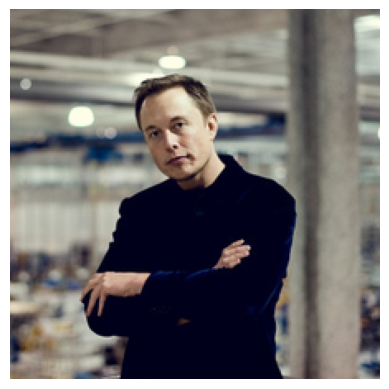


--- Top  5  Predicciones Imagen  0  ---
 9.33% : rugby_ball
 5.45% : cellular_telephone
 5.02% : jersey
 4.64% : ping-pong_ball
 4.02% : ballplayer


In [41]:
predict(model=modeloVGG16,image_path='imgs/elon_musk.jpg')

#### 100 x 100 píxeles

Si en su lugar usamos una imagen de 100 x 100 píxeles de Elon Musk, entonces el modelo piensa que podría mostrar un chaleco antibalas con un 6%. El modelo VGG16 tiene predicciones diferentes, y sigue estando algo confuso.

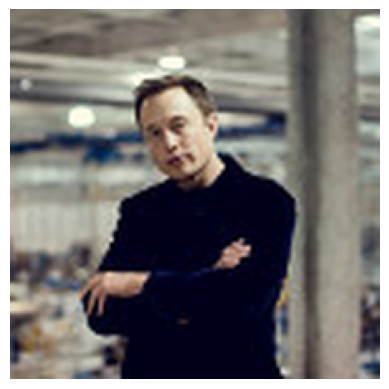


--- Top  5  Predicciones Imagen  0  ---
 6.09% : bulletproof_vest
 6.00% : potter's_wheel
 3.97% : trench_coat
 3.20% : sturgeon
 3.11% : jersey


In [42]:
predict(model=modeloVGG16,image_path='imgs/elon_musk_100x100.jpg')

### Willy Wonka 

#### Gene Wilder

Esta imagen muestra al actor Gene Wilder interpretando a Willy Wonka en la versión de la película de 1971. El modelo VGG16 está muy seguro de que la imagen muestra una pajarita (bow tie, puntuación de alrededor del 50%), lo que es cierto, pero un humano probablemente diría que esta imagen muestra a una persona.

La razón podría ser que el modelo fue entrenado en imágenes de personas con pajaritas que fueron clasificadas como pajaritas en lugar de personas. Así que tal vez el problema es que el nombre de la clase debería ser "persona con pajarita" en lugar de sólo "pajarita".

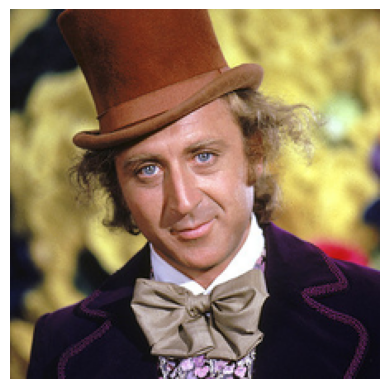


--- Top  5  Predicciones Imagen  0  ---
50.19% : bow_tie
23.64% : cowboy_hat
 6.13% : military_uniform
 5.31% : suit
 2.95% : bolo_tie


In [43]:
predict(model=modeloVGG16,image_path='imgs/willy_wonka_old.jpg')

#### Johnny Depp

Esta imagen muestra al actor Johnny Depp interpretando a Willy Wonka en la versión de 2005 de la película. El modelo piensa que esta imagen muestra "gafa de sol" (sunglass, puntuación aproximada del 38%) o "gafas de sol" (sunglusses, puntuación aproximada del 35%). El modelo VGG16 ha sido entrenado para reconocer gafas de sol enfocado en los ojos, y no a personas. 

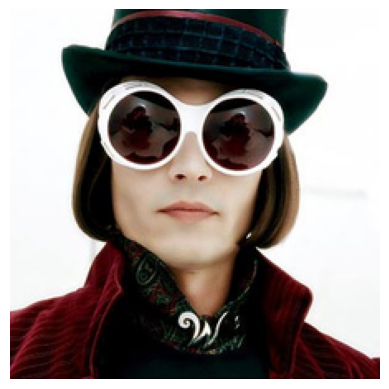


--- Top  5  Predicciones Imagen  0  ---
38.86% : sunglass
35.97% : sunglasses
 3.62% : wig
 1.41% : bonnet
 1.28% : stole


In [44]:
predict(model=modeloVGG16,image_path='imgs/willy_wonka_new.jpg')

## 3. Extracción de Características

Ahora nos centraremos en Transfer Learning. Comenzaremos con la **Extracción de Características**, que consiste en usar representaciones aprendidas por otras redes para extraer características interesantes de nuevas muestras. Tras esta extracción, se usa la nueva representación dada por estas características para alimentar un nuevo clasificador, que (esta vez sí) será entrenado desde cero.

Como hemos visto en los ejemplos anteriores, las CNN usadas para clasificación de imágenes constan de dos partes bien diferenciadas: comienza por una serie de capas alternadas de convolución y pooling (lo que se llama la **base convolucional**), y acaban con un clasificador de capas densas. Nosotros aprovecharemos la base convolucional de la red preentrenada para obtener las nuevas representaciones y entrenaremos un nuevo codificador en la última parte.

Es importante entender porqué reusamos únicamente la base convolucional y no usamos también la parte del clasificador denso. La razón de ignorar esta última parte es simplemente que las representaciones aprendidas en la base convolucional son más genéricas y reutilizables, contienen información acerca de conceptos genéricos, que parecen útiles para todo tipo de problemas de visión artificial. Por otra parte, las representaciones aprendidas por el clasificador son mucho más específicas y relacionadas con el problema concreto para el que se ha entrenado y las clases de ese problema. Además estas capas densas pierden información acerca de dónde se sitúan las características aprendidas, algo que puede ser útil en algunos casos.

El nivel de generalidad (y por tanto de reusabilidad) de las representaciones extraídas por las capas convolucionales dependen de la profundidad de las capas del modelo. Las primeras capas extraen mapas de características muy genéricas y locales (bordes, colores, texturas, etc.), mientras que las capas más profundas extraen conceptos abstractos más elevados (como "orejas", "ojos", etc.). En consecuencia, si el dataset sobre el que se trabaja difiere mucho del dataset original con el que fue entrenada la red, es mejor usar solo las primeras capas, y no la base convolucional completa.

En nuestro caso, intentando clasificar gatos y perros, podríamos llegar a usar incluso las redes densas de la red preentrenada, porque esas clases están contenidas en el problema original, pero nos quedaremos solo con la base convolucional para que el ejemplo sea lo más generalizable posible.

Además del modelo VGG16, Keras trae otros modelos preentrenados aptos para clasificación de imágenes, como [Xception](https://arxiv.org/pdf/1610.02357.pdf), [InceptionV3](https://arxiv.org/abs/1512.00567), [ResNet50](https://arxiv.org/abs/1512.03385), [VGG16](https://arxiv.org/abs/1409.1556), [VGG19](https://arxiv.org/abs/1409.1556), [MobileNet](https://arxiv.org/pdf/1704.04861.pdf), [DenseNet](https://arxiv.org/abs/1707.07012), ...

Recuerda que la primera vez que ejecutes el siguiente código se descargará el modelo preentrenado:

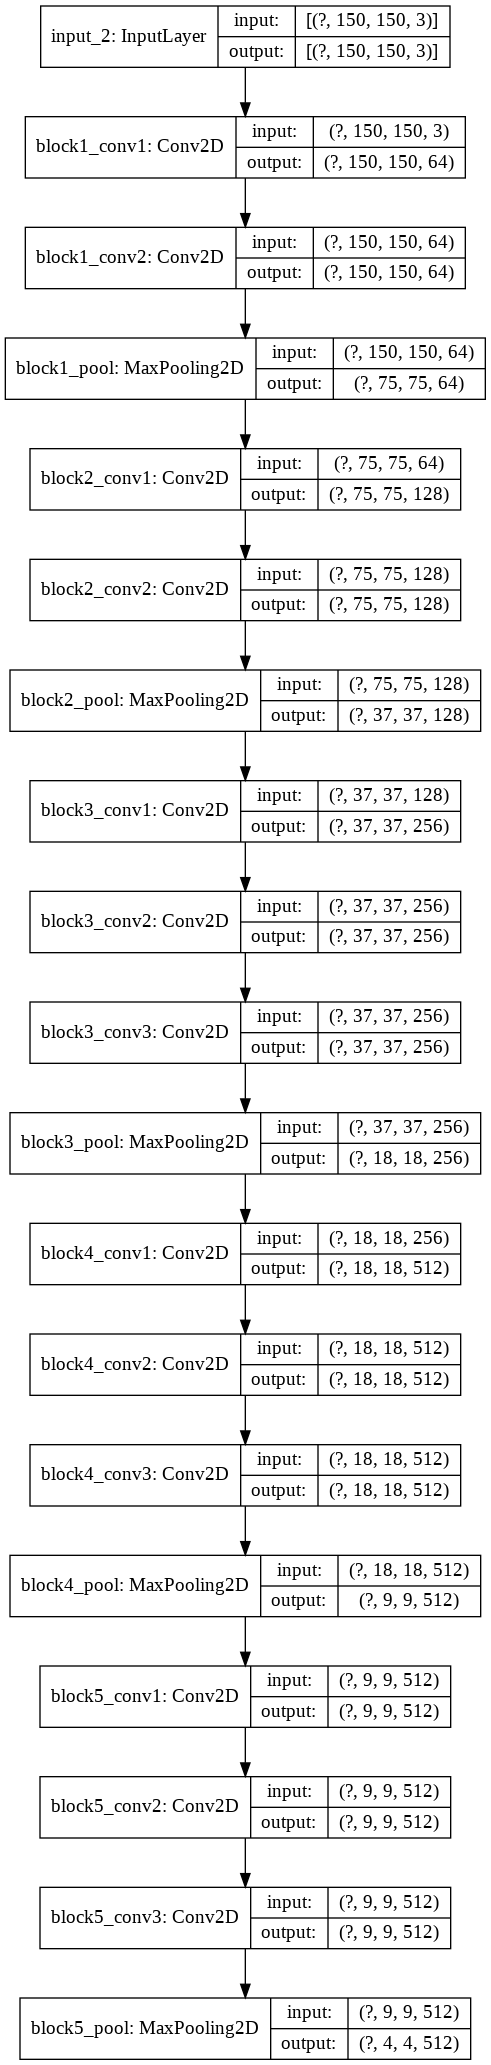

In [18]:
from keras.applications import VGG16
from keras.utils.vis_utils import plot_model

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

plot_model(conv_base, to_file='conv_base_plot.png', show_shapes=True, show_layer_names=True)

Ahora le hemos pasado 3 argumentos al constructor:

* `weights`, especifica el juego de pesos para inicializar el modelo (en nuestro caso, los asociados al problema ImageNet).
* `include_top`, indica si se debe incluir, o no, las capas densas de la red (las que se ajustan a la clasificación de las 1.000 clases de ImageNet).
* `input_shape`, la forma de los tensores de entrada. Es opcional, y si no se indicara se podrían pasar entradas de cualquier tamaño, pero en nuestro caso lo tenemos perfectamente prefijado para que el procedimiento sea similar al que hicimos en el ejemplo anterior. Esta opción está solo disponible si `include_top = false`. Y es que el número de conexiones de la última capa convolucional con la primera capa densa del clasificador es siempre el mismo, y esto hace que el tamaño aceptado en la capa de entrada esté prefijado. Si quitamos el clasificador, podemos cambiar el tamaño de entrada al que queramos.  

Podemos comprobar que la base convolucional de VGG16 es muy parecida a la arquitectura generada para problemas anteriores:

In [19]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

El mapa de características final tiene la forma `(4, 4, 512)`. Aquí conectaremos nuestro clasificador de capas densas.

En este punto, hay dos posibles vías para proceder: 

* Ejecutar la base convolucional sobre el dataset, grabar su salida en un array, y entonces usar estos datos como entrada de un clasificador denso independiente parecido al que vimos anteriormente. Esta solución es rápida y fácil de ejecutar, porque solo requiere ejecutar la base convolucional una vez sobre cada imagen de entrada, que es la parte que más recursos consume del proceso. Por contrario, esta opción no permite hacer uso de *data augmentation*.
* Extender el modelo (`conv_base`) añadiendo capas densas encima, y ejecutar la red completa sobre los datos de entrada. Esta opción permite hacer uso de *data augmentation*, aunque consume muchos más recursos que la primera opción.

Con el fin de poder compararlas, vamos a mostrar ambas técnicas.

Comenzaremos por la primera opción: ejecutar `conv_base` sobre todos los datos para después usar los resultados como datos de entrada en un modelo nuevo. Comenzaremos ejecutando `image_data_generator()` de forma similar a como hicimos en el caso anterior para extraer las imágenes como arrays (y sus etiquetas). Posteriormente, ejecutaremos el método `predict` del modelo sobre estos arrays para extraer las características asociadas.

Primero, recuperemos el dataset de cats and dogs que hicimos en la práctica anterior.

Si estás en Google Colab, o bien recupera el dataset desde tu Google Drive, o bien súbelo desde tu ordenador y descomprímelo con !unzip (como se hizo en la práctica anterior para el dataset original).

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copiamos el dataset y lo decomprimimos
!cp /content/drive/MyDrive/cat_dogs.zip .
!unzip cat_dogs.zip

In [22]:
# Desmontamos
drive.flush_and_unmount()

In [23]:
import os
os.getcwd()

'/content'

In [24]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'cat_dogs'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Observa que dado que los generadores dan datos indefinidamente
            # tenemos que romper (`break`) después de que cada imagen se haya visto una vez
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Las características extraidas tienen la forma `(samples, 4, 4, 512)`. A continuación alimentaremos un clasificador denso, pero hemos de aplanar los tensores, que son en 2D, para pasar a `(samples, 4 * 4 * 512)`:


In [25]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Ya podemos definir nuestro clasificador denso (introducimos una capa de dropout para regularización), y entrenamos con los datos que acabamos de generar con la base convolucional:


In [26]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 7ms/step - loss: 0.5839 - acc: 0.6815 - val_loss: 0.4347 - val_acc: 0.8440
Epoch 2/30
100/100 [==============================] - 1s 5ms/step - loss: 0.4201 - acc: 0.8120 - val_loss: 0.3640 - val_acc: 0.8420
Epoch 3/30
100/100 [==============================] - 1s 5ms/step - loss: 0.3588 - acc: 0.8460 - val_loss: 0.3200 - val_acc: 0.8810
Epoch 4/30
100/100 [==============================] - 1s 5ms/step - loss: 0.3125 - acc: 0.8690 - val_loss: 0.3124 - val_acc: 0.8650
Epoch 5/30
100/100 [==============================] - 1s 5ms/step - loss: 0.2862 - acc: 0.8900 - val_loss: 0.2925 - val_acc: 0.8830
Epoch 6/30
100/100 [==============================] - 1s 5ms/step - loss: 0.2676 - acc: 0.8910 - val_loss: 0.2825 - val_acc: 0.8850
Epoch 7/30
100/100 [==============================] - 1s 5ms/step - loss: 0.2432 - acc: 0.9080 - val_loss: 0.2655 - val_acc: 0.8960
Epoch 8/30
100/100 [==============================] - 1s 5ms/step - loss: 0.

El entrenamiento es muy rápido, ya que solo tiene dos capas densas. Veamos los resultados que se obtienen:


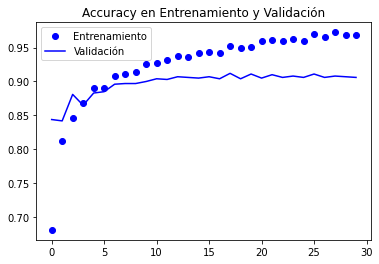

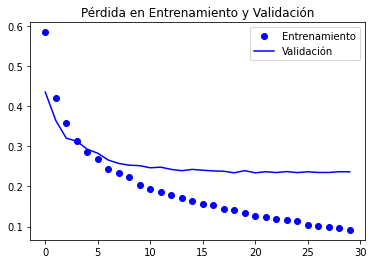

In [27]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

ent_acc = history.history['acc']
val_acc = history.history['val_acc']
ent_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(ent_acc))

plt.plot(epochs, ent_acc, 'bo', label='Entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Validación')
plt.title('Accuracy en Entrenamiento y Validación')
plt.legend()

plt.figure()

plt.plot(epochs, ent_loss, 'bo', label='Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Validación')
plt.title('Pérdida en Entrenamiento y Validación')
plt.legend()

plt.show()


Hemos alcanzado una precisión de ~90%, mucho más elevada que lo que conseguimos con la red convolucional entrenada completamente por nosotros en el ejemplo anterior. Sin embargo, la gráfica muestra que se sigue produciendo un sobreajuste casi desde el principio (incluso habiendo puesto una capa de dropout). Este problema se debe que el modelo hace uso de un dataset muy pequeño, que no ha sido mejorado por medio de data augmentation.

Por ello, pasamos a aplicar la segunda técnica, que es mucho más lenta y cara (quizás no sea conveniente que lo intentes si no tienes una GPU a mano, en ese caso, es preferible que hagas uso de la técnica anterior), pero que permitirá evitar el problema del sobreajuste: extendemos el modelo `conv_base` con nuestras propias capas densas y ejecutamos por completo el entrenamiento de la primera capa hasta la última. 

Como los modelos se comportan igual que las capas, podemos añadir el modelo `conv_base` a un modelo secuencial como si fuera una capa más:

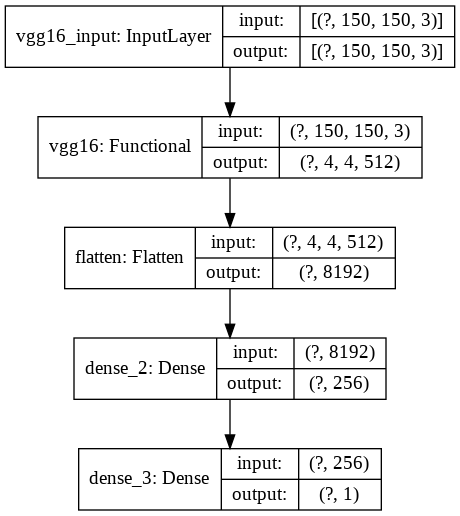

In [28]:
from keras import models
from keras import layers
from keras.utils.vis_utils import plot_model

model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

plot_model(model2, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

El modelo resultante es:
![](https://github.com/miguelamda/DL/blob/master/5.%20Redes%20Convolucionales/imgs/model2_plot.png?raw=1)

In [29]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


Como puedes observar, la base convolucional de VGG16 tiene 14.714.688 parámetros, y sobre ella hemos añadido un clasificador con otros 2 millones de parámetros.

Antes de compilar y entrenar tu modelo, recuerda que es importante **congelar** la base convolucional, lo que significa que durante el proceso de entrenamiento los pesos de sus capas **no** serán modificados. Si no se hace así, las representaciones aprendidas en el entrenamiento original se modificarían. Como las capas densas que se añaden se inicializan aleatoriamente, habría grandes modificaciones sobre los pesos que se propagarían a través de la red, lo que destruiría el aprendizaje previo.

Keras proporciona la propiedad `trainable` a las capas para indicar si deben estar congeladas o no:

In [30]:
print('Número de pesos entrenables antes de congelar la base convolucional:', len(model2.trainable_weights))

Número de pesos entrenables antes de congelar la base convolucional: 30


In [31]:
conv_base.trainable = False

model2.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [32]:
print('Número de pesos entrenables tras congelar la base convolucional:', len(model.trainable_weights))

Número de pesos entrenables tras congelar la base convolucional: 4


Indica 4 pesos por entrenar porque son 2 capas, y en cada capa se considera la matriz de pesos y la de bias. Es importante tener en cuenta que tras congelar las capas debes compilar el modelo, si no, no tendrá efecto.

Ya podemos entrenar el modelo haciendo uso de la misma técnica de data augmentation que vimos antes:

In [34]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Observa que los datos de validación no se aumentan!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # Este es el directorio objetivo
        train_dir,
        # Todas las imágenes serán redimensionadas a 150x150
        target_size=(150, 150),
        batch_size=20,
        # Dado que usamos la pérdida binary_crossentropy, necesitamos etiquetas binarias
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

entrenamiento = model2.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 - 25s - loss: 0.3132 - acc: 0.8625 - val_loss: 0.2506 - val_acc: 0.8890
Epoch 2/30
100/100 - 25s - loss: 0.3004 - acc: 0.8665 - val_loss: 0.2463 - val_acc: 0.8960
Epoch 3/30
100/100 - 25s - loss: 0.3103 - acc: 0.8665 - val_loss: 0.2454 - val_acc: 0.8980
Epoch 4/30
100/100 - 25s - loss: 0.2973 - acc: 0.8705 - val_loss: 0.2441 - val_acc: 0.8950
Epoch 5/30
100/100 - 25s - loss: 0.2823 - acc: 0.8825 - val_loss: 0.2657 - val_acc: 0.8800
Epoch 6/30
100/100 - 25s - loss: 0.2931 - acc: 0.8785 - val_loss: 0.2499 - val_acc: 0.8980
Epoch 7/30
100/100 - 25s - loss: 0.2975 - acc: 0.8725 - val_loss: 0.2412 - val_acc: 0.8920
Epoch 8/30
100/100 - 26s - loss: 0.3142 - acc: 0.8605 - val_loss: 0.2453 - val_acc: 0.8950
Epoch 9/30
100/100 - 25s - loss: 0.2877 - acc: 0.8700 - val_loss: 0.2367 - val_acc: 0.8970
Epoch 10/30
100/100 - 25s - loss: 0.2866 - acc: 0.8745 - val_loss: 0.2393 - val_acc: 0.8990
Epoch

Y grabamos el modelo resultante:


In [35]:
model.save('cats_and_dogs_3.h5')

Si vemos los resultados obtenidos:


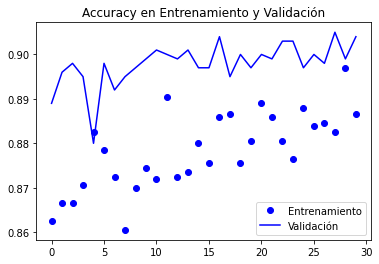

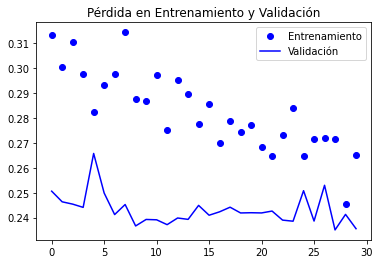

In [36]:
ent_acc = entrenamiento.history['acc']
val_acc = entrenamiento.history['val_acc']
ent_loss = entrenamiento.history['loss']
val_loss = entrenamiento.history['val_loss']

epochs = range(len(ent_acc))

plt.plot(epochs, ent_acc, 'bo', label='Entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Validación')
plt.title('Accuracy en Entrenamiento y Validación')
plt.legend()

plt.figure()

plt.plot(epochs, ent_loss, 'bo', label='Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Validación')
plt.title('Pérdida en Entrenamiento y Validación')
plt.legend()

plt.show()

Vemos que alcanzamos también una precisión del 90%.


## 3. Ajuste Fino (Fine Tuning)

Otra técnica muy usada para la reutilización de modelos, complementaria a la de extracción de características, consiste en lo que se conoce como **Ajuste Fino**, que consiste en descongelar algunas de las capas superiores de la base convolucional (usada para la extracción de características) y entrenarlas conjuntamente con las capas de clasificación que se han añadido sobre ellas. Se llama así porque ajusta ligeramente las representaciones más abstractas del modelo que se reusa con el fin de que se adapten al problema concreto que estamos intentando resolver.

Antes dijimos que era necesario congelar la base convolucional de VGG16 con el fin de poder entrenar el clasificador (inicializado aleatoriamente) que se ha situado encima. Por las mismas razones, solo es posible hacer un ajuste fino de las capas superiores si el clasificador que se pone encima ya ha sido entrenado de alguna forma porque, en caso contrario, el error se propagará hacia el interior de la red y perderá de nuevo las representaciones aprendidas por esas capas. Por tanto, los pasos a seguir para un ajuste fino serán:

1. Añadir la red personalizada sobre la base de la red preentrenada.
2. Congelar la base preentrenada.
3. Entrenar la parte que has añadido.
4. Descongelar algunas capas superiores de la base preentrenada.
5. Entrenar conjuntamente todas las capas (las que has descongelado y las que has añadido).

Puedes encontrar información interesante sobre Ajuste Fino en estos dos posts de Felix Yu: [Parte 1](https://flyyufelix.github.io/2016/10/03/fine-tuning-in-keras-part1.html) y [Parte 2](https://flyyufelix.github.io/2016/10/08/fine-tuning-in-keras-part2.html).

A lo largo de este ejemplo ya hemos completado las tres primeras fases de este proceso, así que comenzaremos por el 4º. Recordemos previamente cómo es la base convolucional:

In [37]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     


Lo que haremos será descongelar (y ajustar fino) las capas a partir del bloque 3 (`block3_conv1`).Podríamos intentar entrenar aún más capas, pero se debe considerar que:

* Las capas más tempranas de la base convolucional codifican características más genéricas y reutilizables, por lo que es muy probable que tengan ya el aprendizaje que nos interesa.
* Cuantos más parámetros entrenemos, mayor riesgo de sobreajuste. Tenemos cerca de 15 millones de parámaetros en nuestra base convolucional, y un dataset pequeño, así que es muy arriesgado intentar entrenar muchos parámetros.

Descongelemos las capas que necesitamos:

In [38]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Ahora ya podemos ajustar la red. Lo haremos con el optimizador `RMSprop` pero usando una tasa de aprendizaje baja, para limitar las magnitud de las modificaciones sobre las representaciones ya aprendidas (por eso se llama _Ajuste Fino_).


In [39]:
model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model2.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 27s 273ms/step - loss: 0.2808 - acc: 0.8770 - val_loss: 0.2274 - val_acc: 0.9110
Epoch 2/100
100/100 [==============================] - 27s 272ms/step - loss: 0.2568 - acc: 0.8925 - val_loss: 0.2054 - val_acc: 0.9200
Epoch 3/100
100/100 [==============================] - 27s 270ms/step - loss: 0.2432 - acc: 0.9040 - val_loss: 0.2027 - val_acc: 0.9250
Epoch 4/100
100/100 [==============================] - 27s 270ms/step - loss: 0.2161 - acc: 0.9095 - val_loss: 0.2021 - val_acc: 0.9270
Epoch 5/100
100/100 [==============================] - 27s 270ms/step - loss: 0.1979 - acc: 0.9230 - val_loss: 0.2034 - val_acc: 0.9210
Epoch 6/100
100/100 [==============================] - 27s 270ms/step - loss: 0.1882 - acc: 0.9230 - val_loss: 0.1916 - val_acc: 0.9260
Epoch 7/100
100/100 [==============================] - 27s 270ms/step - loss: 0.1875 - acc: 0.9255 - val_loss: 0.1970 - val_acc: 0.9230
Epoch 8/100
100/100 [===========================

Como ya suele ser habitual, grabamos el modelo entrenado:


In [40]:
model.save('cats_and_dogs_4.h5')

Y mostramos los resultados obtenidos:


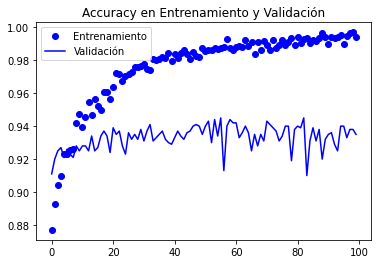

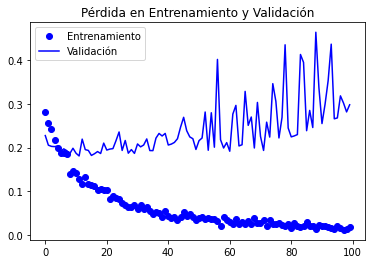

In [41]:
ent_acc = history.history['acc']
val_acc = history.history['val_acc']
ent_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(ent_acc))

plt.plot(epochs, ent_acc, 'bo', label='Entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Validación')
plt.title('Accuracy en Entrenamiento y Validación')
plt.legend()

plt.figure()

plt.plot(epochs, ent_loss, 'bo', label='Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Validación')
plt.title('Pérdida en Entrenamiento y Validación')
plt.legend()

plt.show()


Al igual que con el ejemplo anterior, suavizamos las curvas para extraer más información:

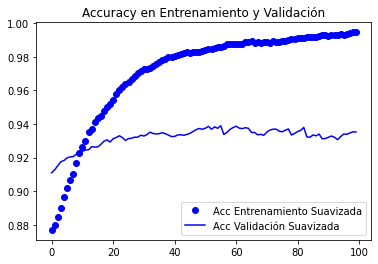

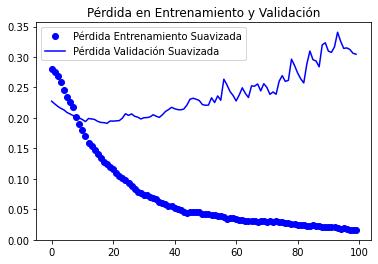

In [42]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(ent_acc), 'bo', label='Acc Entrenamiento Suavizada')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Acc Validación Suavizada')
plt.title('Accuracy en Entrenamiento y Validación')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(ent_loss), 'bo', label='Pérdida Entrenamiento Suavizada')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Pérdida Validación Suavizada')
plt.title('Pérdida en Entrenamiento y Validación')
plt.legend()

plt.show()


Observamos que se alcanza una mejora de un 6%, alcanzando el 96%. 

Hay algo que debemos notar, y es que la curva de pérdida  no parece mejorar (incluso empeora),  a pesar de que la accuracy permanece estable o incluso mejora, ¿cómo es posible? La respuesta es simple, lo que se representa es una media de los valores de pérdida puntuales, pero lo que importa para la precisión es la distribución de los valores de pérdida, no su media, porque la precisión es el resultado de la binarización del valor predicho, por lo que el modelo puede mejorar incluso aunque esos valores se modifiquen ligeramente.

Por fin, podemos evaluar el modelo sobre los datos de test:

In [43]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model2.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
test acc: 0.9399999976158142



Donde obtenemos una precisión del 96,5%, y solo con 2.000 muestras, no con las 20.000 que venían en la competición original de Kaggle de la que se han extraido nuestras muestras.


## 3. Conclusiones

* Las redes convolucionales aportan los mejores modelos de ML para tareas de visión artificial. Incluso es posible entrenar una red desde cero sobre pocas muestras obteniendo resultados decentes.
* El sobreajuste es el principal problema cuando se trabaja con datasets pequeños. Entre las técnicas de regularización vistas, **data augmentation** puede ser una ayuda esencial cuando se trabaja con imágenes.
* Podemos descargar modelos pre-entrenados directamente desde Keras, y emplearlos para intentar clasificar imágenes. Aunque podemos encontrarnos resultados extraños si el dominio de nuestra tarea es distinta a la del dataset ImageNet.
* Es fácil reutilizar una red convolucional previamente entrenada por medio de la **extracción de características**. Es rápido y funciona bien con datasets pequeños. 
  * Primero quita el clasificador al modelo pre-entrenado.
  * Úsalo para hacer inferencia sobre el dataset. Guarda el resultado en un array.
  * Ahora entrena un nuevo modelo, que va a ser solo tu clasificador, sobre ese array.
* Como complemento a la extracción de características, el **ajuste fino** puede adaptar las representaciones aprendidas previamente por un modelo dado para ajustarlo a un problema distinto. Los recursos necesarios son más elevados, pero si se dispone de los recursos computacionales, el rendimiento obtenido es considerablemente superior.
  * Quita el clasificador al modelo pre-entrenado.
  * Crea un nuevo modelo cuya primera parte sea lo anterior, con las capas bloqueadas.
  * Añade tu nuevo clasificador.
  * Entrena el clasificador (esto es, hacer extracción de características).
  * Desbloquea algunas capas y ajusta un learning rate bajo.
  * Re-entrena más épocas (ajuste fino).
* Si el nuevo dataset que vas a usar es muy distinto al que fue usado para entrenar el modelo pre-entrenado (por ejemplo, tu dataset trata sobre [imágenes del fondo del ojo](https://www.cs.us.es/~fsancho/ficheros/IAML/UdeSevilla_slides.pdf)), puedes intentar a hacer transfer learning desde una capa anterior. Cuanto más atrás vayas, las características detectadas serán más básicas. Eso sí, siempre mantén el modelo pre-entrenado desde la primera capa hasta la que quieras usar.